In [30]:
import os
from random import shuffle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from PIL import Image
import random

In [31]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [32]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
IMAGE_SIZE = (64, 64)
LABELS = {'dog' : 1, 'cat' : 0}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 20

In [33]:
def make_data_batch(df, indxs, batch_size):
    Xs = []
    Ys = []
    
    transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMAGE_SIZE),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4884, 0.4551, 0.4170], std=[0.2256, 0.2210, 0.2214])])
    i = 0
    while True:
        
        info = df.iloc[indxs[i]]
        fname = info['file_name']
        y = int(info['label'])
            
        image = Image.open(fname)
            
        tensor = transform(image)
        tensor = np.array(tensor)                
        tensor = tensor / 255.
            
        Xs.append(tensor)
        Ys.append(y)
        i += 1
        if len(Xs) == batch_size:
            X = Xs
            Y = Ys
            Xs = []
            Ys = []
            yield X, Y

In [34]:
def make_data(df, indxs):
    Xs = []
    Ys = []
    
    transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMAGE_SIZE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4884, 0.4551, 0.4170], std=[0.2256, 0.2210, 0.2214])])

    for i in tqdm(range(len(indxs))):
                        
        info = df.iloc[indxs[i]]
        fname = info['file_name']
        y = int(info['label'])
            
        image = Image.open(fname)

        tensor = transform(image)
        tensor = np.array(tensor)
        tensor = tensor / 255.
        
        Xs.append(tensor)
        Ys.append(y)
    
    return Xs, Ys

In [35]:
file_names_train = os.listdir(TRAIN_PATH)
shuffle(file_names_train)

file_names_test = os.listdir(TEST_PATH)

In [36]:
all_data_df = pd.DataFrame({'file_name': [], 'label' : []})
for file in tqdm(file_names_train):
    path = TRAIN_PATH + file
    label = file.split('.')[0]
    all_data_df = all_data_df.append({'file_name' : path, 'label' : LABELS[label]}, ignore_index=True)


100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:41<00:00, 602.35it/s]


In [37]:
all_data_df.head()

,file_name,label
0,train/dog.7543.jpg,1.0
1,train/dog.5932.jpg,1.0
2,train/dog.6037.jpg,1.0
3,train/dog.5233.jpg,1.0
4,train/dog.5498.jpg,1.0


In [38]:
validation_df = all_data_df.iloc[20000:]
train_df = all_data_df.iloc[:20000]

In [39]:
print(len(train_df))
print(len(validation_df))

20000
5000


In [40]:
count_of_dogs_train = len(train_df.query('label == 1.0'))
count_of_cats_train = len(train_df.query('label == 0.0'))

Text(0.5, 0, 'Labels')

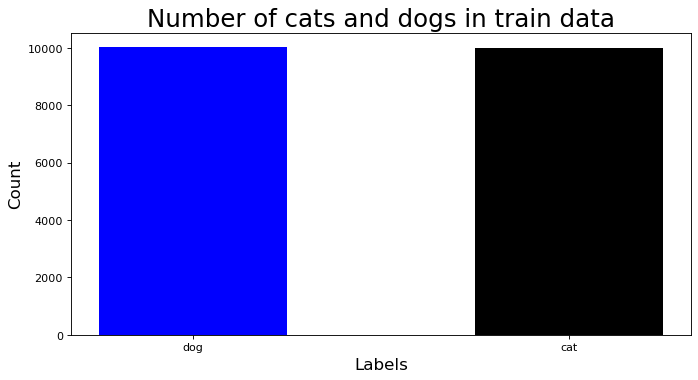

In [41]:
plt.figure(figsize=(10,5), dpi= 80)
plt.bar('dog', count_of_dogs_train, color='blue', width=.5)
plt.bar('cat', count_of_cats_train, color='black', width=.5)
plt.title('Number of cats and dogs in train data', fontsize=22)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Labels', fontsize=15)

In [42]:
count_of_dogs_validation = len(validation_df.query('label == 1.0'))
count_of_cats_validation = len(validation_df.query('label == 0.0'))

Text(0.5, 0, 'Labels')

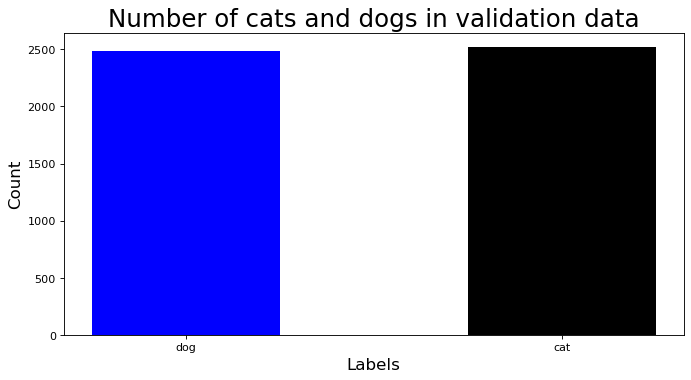

In [43]:
plt.figure(figsize=(10,5), dpi= 80)
plt.bar('dog', count_of_dogs_validation, color='blue', width=.5)
plt.bar('cat', count_of_cats_validation, color='black', width=.5)
plt.title('Number of cats and dogs in validation data', fontsize=22)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Labels', fontsize=15)

In [44]:
train_indxes = np.array([i for i in range(len(train_df))])
validation_indexes = np.array([i for i in range(len(validation_df))])

validation_data = make_data(validation_df, validation_indexes)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 286.71it/s]


In [45]:
train_indxes

array([    0,     1,     2, ..., 19997, 19998, 19999])

In [46]:
train_df.tail

<bound method NDFrame.tail of                  file_name  label
0       train/dog.7543.jpg    1.0
1       train/dog.5932.jpg    1.0
2       train/dog.6037.jpg    1.0
3       train/dog.5233.jpg    1.0
4       train/dog.5498.jpg    1.0
...                    ...    ...
19995   train/cat.8015.jpg    0.0
19996   train/cat.2251.jpg    0.0
19997   train/dog.3573.jpg    1.0
19998  train/cat.10646.jpg    0.0
19999   train/dog.6947.jpg    1.0

[20000 rows x 2 columns]>

In [47]:
(validation_data[0][0].shape)

(3, 64, 64)

In [48]:
X_val = torch.FloatTensor(validation_data[0])

Y_val = torch.LongTensor(validation_data[1])

In [61]:
def train(net, x_val, y_val, epochs=30):
    
    val_accuracy_history = []
    val_loss_history = []
    
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-4)
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    
    for epoch in range(epochs):
    
        gen = make_data_batch(train_df, train_indxes, batch_size)
        
        for start_index in range(len(train_indxes) // batch_size):
            
            optimizer.zero_grad()
            net.train()

            batch = next(gen)
            x_batch = torch.FloatTensor(batch[0]).to(device)
            y_batch = torch.LongTensor(batch[1]).to(device)

            preds = net.forward(x_batch)
            loss_value = loss(preds, y_batch)
            
            accuracy_train = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
            
            
            col_r = int(start_index / epochs)

            print('#' * col_r + '-' * (epochs - col_r) + ' epoch: ' + str(epoch) + '| accuracy train: ' + 
                  str(round(float(accuracy_train), 4)) + '| loss train: ' + 
                  str(round(float(loss_value.data), 4)), end='\r')

            loss_value.backward()
            optimizer.step()
            
            

        net.eval()
        val_preds = net.forward(x_val)
        loss_val = loss(val_preds, y_val).data.cpu()
        val_loss_history.append(loss_val)
        

        accuracy = (val_preds.argmax(dim=1) == y_val).float().mean().data.cpu()
        
        val_accuracy_history.append(accuracy)
        print()
        print('accuracy validation:', accuracy, '| loss validation:', loss_val)

    return val_accuracy_history, val_loss_history


In [62]:
class Model_1(torch.nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        
        self.conv1       = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.act1        = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(32)
        self.pool1       = torch.nn.MaxPool2d(2, 2)
        self.do1         = torch.nn.Dropout2d(0.25)
        
        self.conv2       = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act2        = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(64)
        self.pool2       = torch.nn.MaxPool2d(2, 2)
        self.do2         = torch.nn.Dropout2d(0.25)
        
        self.conv3       = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.act3        = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(128)
        self.pool3       = torch.nn.MaxPool2d(2, 2)
        self.do3         = torch.nn.Dropout2d(0.25)
        
        self.flat        = torch.nn.Flatten()
        
        self.fc1         = torch.nn.Linear(8192, 512)
        self.batch_norm4 = torch.nn.BatchNorm1d(512)
        self.do4         = torch.nn.Dropout(0.5)
        self.act4        = torch.nn.ReLU()
        
        self.fc2         = torch.nn.Linear(512, 2)
        self.act5        = torch.nn.Sigmoid()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = self.do1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = self.do2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)
        x = self.do3(x)
        
        x = self.flat(x)
        
        x = self.fc1(x)
        x = self.batch_norm4(x)
        x = self.do4(x)
        x = self.act4(x)
        
        x = self.fc2(x)
        x = self.act5(x)
        
        return x

In [63]:
final_accuracies = {}
final_losses = {}

In [64]:
model_1 = Model_1()

final_accuracies['Model_1'], final_losses['Model_1'] = \
        train(model_1, X_val, Y_val)

################################# epoch: 0| accuracy train: 0.7| loss train: 0.62916
accuracy validation: tensor(0.6912) | loss validation: tensor(0.5939)
################################# epoch: 1| accuracy train: 0.9| loss train: 0.46862
accuracy validation: tensor(0.7388) | loss validation: tensor(0.5573)
################################# epoch: 2| accuracy train: 0.9| loss train: 0.45999
accuracy validation: tensor(0.7630) | loss validation: tensor(0.5339)
################################# epoch: 3| accuracy train: 1.0| loss train: 0.39411
accuracy validation: tensor(0.7726) | loss validation: tensor(0.5252)
################################# epoch: 4| accuracy train: 0.75| loss train: 0.5273
accuracy validation: tensor(0.7746) | loss validation: tensor(0.5256)
################################# epoch: 5| accuracy train: 0.85| loss train: 0.4503
accuracy validation: tensor(0.7824) | loss validation: tensor(0.5194)
################################# epoch: 6| accuracy train: 0.95| loss

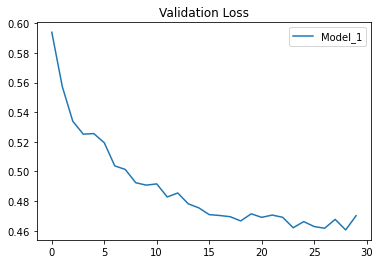

In [65]:
for experiment_id in final_losses.keys():
    plt.plot(final_losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

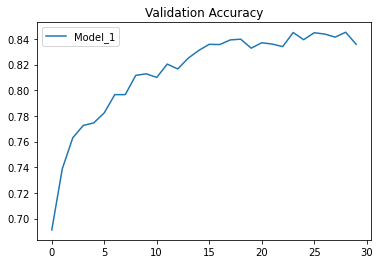

In [66]:
for experiment_id in final_accuracies.keys():
    plt.plot(final_accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

In [67]:
torch.save(model_1.state_dict(), 'Model_1.pkl')

In [68]:
my_model = Model_1()
my_model.load_state_dict(torch.load('Model_1.pkl'))
my_model.eval()

Model_1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do3): Dropout2d(p=0.25, inplace=False)
  (flat): Flatten(start_dim=1, en

In [89]:
test_df = pd.DataFrame({'id': [], 'label' : []})

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMAGE_SIZE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4884, 0.4551, 0.4170], std=[0.2256, 0.2210, 0.2214])])

for file in tqdm(file_names_test):
    
    image = Image.open(TEST_PATH + file)
    tensor = transform(image)
    tensor = np.array(tensor)
    tensor = tensor / 255.
    
    tensor = tensor[np.newaxis, ...]
    X = torch.FloatTensor(tensor)
    
    pred = my_model.forward(X)
    Y = pred.argmax(dim=1)[0]
    
    test_df = test_df.append({'id' : int(file[:-4]), 'label' : int(Y)}, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:47<00:00, 115.91it/s]


In [90]:
test_df.head()

,id,label
0,1.0,1.0
1,10.0,0.0
2,100.0,0.0
3,1000.0,0.0
4,10000.0,1.0


In [99]:
test_df = test_df.sort_values('id').astype({'id' : 'Int64', 'label' : 'Int64', })

In [104]:
test_df.head()

,id,label
0,1,1
3612,2,1
4723,3,1
5834,4,1
6945,5,0


In [105]:
test_df.to_csv('answer.csv', index=False)